  MAE:  13.99
  RMSE: 18.03
R^2 :  0.2275


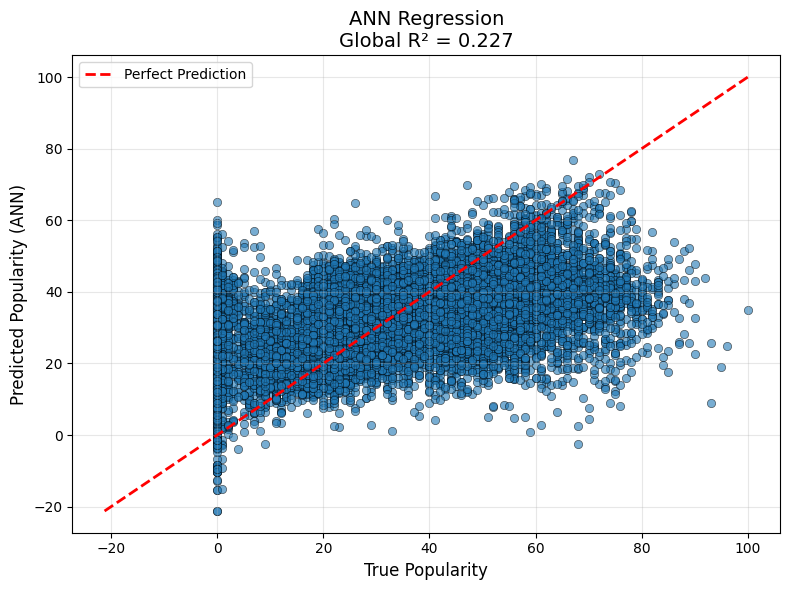

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from utils_io import load_step, save_step

y_train = load_step("y_train")
y_test = load_step("y_test")
X_train_scaled = load_step("X_train_scaled")
X_test_scaled = load_step("X_test_scaled")


# Make sure y is 1D (you already did this before, but it's safe & cheap)
y_train_arr = np.ravel(y_train)
y_test_arr = np.ravel(y_test)

# Define the ANN (MLPRegressor)
ann_reg = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # 2 hidden layers: 64 and 32 neurons
    activation="relu",
    solver="adam",
    alpha=1e-3,                    # L2 regularization
    learning_rate="adaptive",
    max_iter=1000,
    early_stopping=True,           # uses 10% of training data as validation
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

# Fit on the *scaled* features
ann_reg.fit(X_train_scaled, y_train_arr)

# Predict on test set
y_pred_ann = ann_reg.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_ann)
mae = mean_absolute_error(y_test, y_pred_ann)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ann))

print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"R^2 :  {r2:.4f}")



# Optional: Predicted vs Actual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_arr, y_pred_ann, alpha=0.6, edgecolors="k", linewidth=0.5)
min_val = min(y_test_arr.min(), y_pred_ann.min())
max_val = max(y_test_arr.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Prediction")
plt.xlabel("True Popularity", fontsize=12)
plt.ylabel("Predicted Popularity (ANN)", fontsize=12)
plt.title(f"ANN Regression\nGlobal R² = {r2_ann:.3f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Running Grid Search for ANN...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=1000; total time=   9.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=500; total time=   9.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=1000; total time=  10.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=500; total time=  10.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=500; total time=  10.1s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=1000; total time=  10.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=500; total time=  11.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=1000; total time=  11.7s
[CV] END alpha=0.0001, hidden_layer_siz

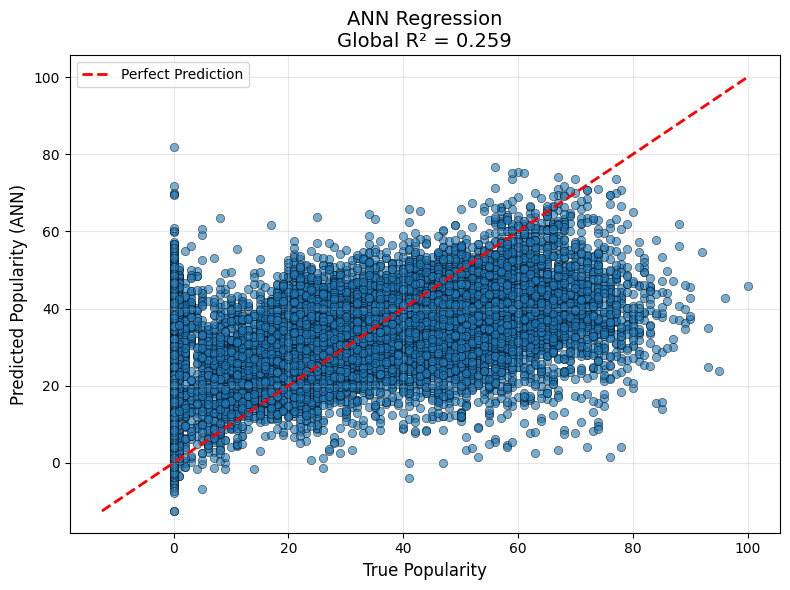

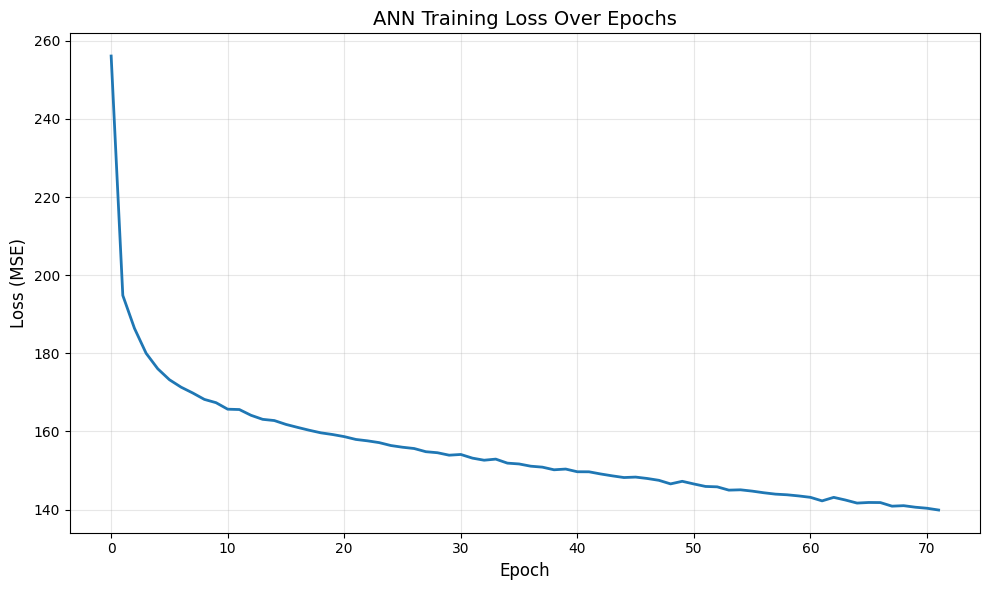

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from utils_io import load_step, save_step

# ============================================================================
# LOAD DATA
# ============================================================================

X_train_scaled = load_step("step3_X_train_scaled")
X_test_scaled = load_step("step3_X_test_scaled")
y_train = load_step("step3_y_train")
y_test = load_step("step3_y_test")

y_train_arr = np.ravel(y_train)
y_test_arr = np.ravel(y_test)

# ============================================================================
# HYPERPARAMETER OPTIMIZATION
# ============================================================================

param_grid = {
    "hidden_layer_sizes": [
        (64,),
        (128,),
        (64, 32),
        (128, 64),
        (128, 64, 32),
    ],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
    "max_iter": [500, 1000],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=MLPRegressor(
        activation="relu",
        solver="adam",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42
    ),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("Running Grid Search for ANN...")
grid.fit(X_train_scaled, y_train_arr)

print("\n" + "="*60)
print("Best params:", grid.best_params_)
print("Best CV score (neg MSE):", grid.best_score_)
print("="*60)

# ============================================================================
# TRAIN ANN WITH BEST PARAMS
# ============================================================================

best_ann = MLPRegressor(
    **grid.best_params_,
    activation="relu",
    solver="adam",
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

best_ann.fit(X_train_scaled, y_train_arr)
y_pred_ann = best_ann.predict(X_test_scaled)

# ============================================================================
# EVALUATION
# ============================================================================

mse_ann = mean_squared_error(y_test_arr, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_arr, y_pred_ann)

print("\nArtificial Neural Network (MLPRegressor)")
print(f"MSE :  {mse_ann:.4f}")
print(f"RMSE:  {rmse_ann:.4f}")
print(f"R^2 :  {r2_ann:.4f}")

# ============================================================================
# VISUALIZATION: Predicted vs Actual
# ============================================================================

plt.figure(figsize=(8, 6))
plt.scatter(y_test_arr, y_pred_ann, alpha=0.6, edgecolors="k", linewidth=0.5)
min_val = min(y_test_arr.min(), y_pred_ann.min())
max_val = max(y_test_arr.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Prediction")
plt.xlabel("True Popularity", fontsize=12)
plt.ylabel("Predicted Popularity (ANN)", fontsize=12)
plt.title(f"ANN Regression\nGlobal R² = {r2_ann:.3f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION: Training Loss Curve
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(best_ann.loss_curve_, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('ANN Training Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
